**Introduction**

Pneumonia is a serious respiratory infection that can cause inflammation of the air sacs in the lungs, leading to symptoms such as cough, chest pain, fever, and difficulty breathing. Early detection is critical for effective treatment, as pneumonia can progress rapidly and lead to severe complications if left untreated. Traditionally, diagnosing pneumonia involves the interpretation of medical imaging, such as **chest X-rays** or **CT scans**, by radiologists. However, the increasing volume of medical imaging data and the shortage of skilled radiologists have led to an increased interest in automated methods for **pneumonia detection**.


## **Importing Libraries**

In [1]:
# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50

# Image Processing Libraries
import cv2

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# File and Operating System Libraries
import os

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

# GPU Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.config.list_physical_devices('GPU'))

IMG_PATH = '/rsna-pneumonia-processed-dataset/Training/Images/'
MODEL_PATH = '/pneumonia-detection-using-resnet50/tensorflow2/model-v1.1/1/lung_detection_1.keras'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Dataset Overview**

#### **Goal**: 
Build an algorithm to identify pneumonia in chest X-rays by locating lung opacities.

- **Total Rows**: 30,227
- **Unique Patients**: 26,684

### **Folder Structure**

- **Train**
  - **Images:** Contains the processed PNG images for the training set.
  - **Masks:** Folder containing binary masks corresponding to the bounding boxes for the training set.
- **Test**: Contains the processed PNG images for the test set.
- **Train_metadata.csv**: Metadata for the training set, including patient IDs, bounding box coordinates, and labels.
- **Test_metadata.csv**: Metadata for the test set, including patient IDs.

### **Key Data Columns**
- **patientId:** Unique identifier for each patient/image.
- **x:** The x-coordinate of the top-left corner of the bounding box.
- **y:** The y-coordinate of the top-left corner of the bounding box.
- **width:** The width of the bounding box.
- **height:** The height of the bounding box.
- **Target:** Binary label indicating the presence of pneumonia (1 for pneumonia, 0 for no pneumonia).
- **class:** The class/category of pneumonia (e.g. Lung Opacity, Normal, No Lung Opacity / Not Normal ).
- **age:** The age of the patient at the time the image was taken.
- **sex:** The sex/gender of the patient (e.g., Male or Female).
- **modality:** The imaging modality used (e.g., X-ray, CT scan).
- **position:** The position of the patient during imaging (e.g., AP for anterior-posterior, PA for posterior-anterior).

### **Distribution**
- **No Lung Opacity / Not Normal:** 11,821 samples
- **Normal:** 8,851 samples
- **Lung Opacity:** 9,555 samples



In [2]:
train_metadata = pd.read_csv('/rsna-pneumonia-processed-dataset/stage2_train_metadata.csv')
test_metadata = pd.read_csv('/rsna-pneumonia-processed-dataset/stage2_test_metadata.csv')

In [3]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   age        30227 non-null  int64  
 8   sex        30227 non-null  object 
 9   modality   30227 non-null  object 
 10  position   30227 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 2.5+ MB


In [4]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   patientId         3000 non-null   object
 1   PredictionString  3000 non-null   object
 2   age               3000 non-null   int64 
 3   sex               3000 non-null   object
 4   modality          3000 non-null   object
 5   position          3000 non-null   object
dtypes: int64(1), object(5)
memory usage: 140.8+ KB


In [5]:
train_metadata.describe().style.background_gradient()

,x,y,width,height,Target,age
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108,46.797764
std,204.574172,148.940488,59.289475,157.750755,0.464963,16.892940
min,2.000000,2.000000,40.000000,45.000000,0.000000,1.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000,34.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000,49.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000,59.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000,155.000000


In [6]:
train_metadata.describe(include='O')

,patientId,class,sex,modality,position
count,30227,30227,30227,30227,30227
unique,26684,3,2,1,2
top,ee820aa5-4804-4984-97b3-f0a71d69702f,No Lung Opacity / Not Normal,M,CR,AP
freq,4,11821,17216,30227,15297


In [7]:
print('Total rows in train_labels:',train_metadata.shape[0])
print('Total unique patients in train_labels:',train_metadata['patientId'].nunique())

Total rows in train_labels: 30227
Total unique patients in train_labels: 26684


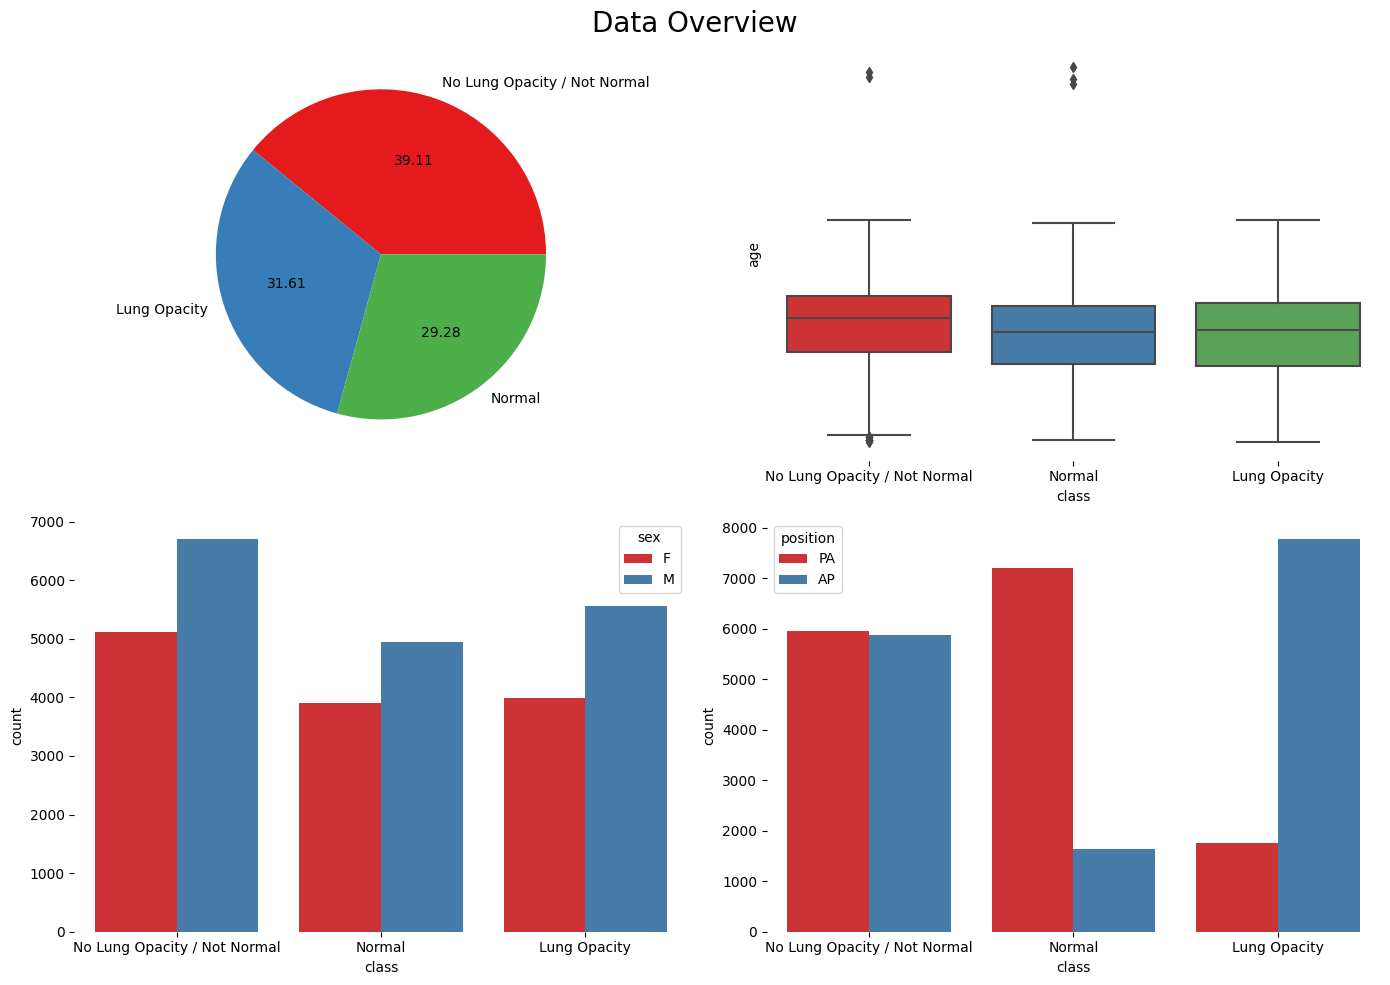

In [8]:
plt.figure(figsize=(14,10))
sns.set_palette('Set1')

plt.subplot(221)
agg_data = train_metadata['class'].value_counts()
plt.pie(agg_data,autopct='%4.2f',labels=agg_data.index)

plt.subplot(222)
sns.boxplot(train_metadata,x='class',y='age')
plt.yticks([])
plt.box(False)

plt.subplot(223)
sns.countplot(train_metadata,x='class',hue='sex')
plt.box(False)

plt.subplot(224)
sns.countplot(train_metadata,x='class',hue='position')
# plt.yticks([])
plt.box(False)

plt.suptitle('Data Overview',fontsize=20)
plt.tight_layout()
plt.show()

# **Data Processing**

In [9]:
train_metadata.drop(['x','y','width','height'],axis=1,inplace=True)
train_metadata.drop_duplicates(inplace=True)

In [10]:
# Split the unique patient IDs into training and validation sets
train_patient_id, val_patient_id, train_target, val_target = train_test_split(
    train_metadata.patientId,  # Features to split
    train_metadata['Target'],     # Target labels to stratify by
    test_size=0.1,  # 10% of the data will be used for validation
    stratify=train_metadata['Target'],  # Ensure that the split maintains the proportion of each class
    random_state=123  # Set a seed for reproducibility
)

# Compute class weights based on the training labels
class_weights = compute_class_weight(
    'balanced',  # This will automatically adjust for class imbalance
    classes=np.unique(train_metadata.Target),  # Unique classes in the target
    y=train_metadata.Target  # The target class labels for training
)

# Create a dictionary mapping each class to its weight
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# **Custom Data Generator**

In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, patient_id, target_class, batch_size=32, size=(512, 512), seed=1, shuffle=True, **kwargs):
        """
        Custom data generator for segmentation tasks.
        
        Args:
        - img_dir: Directory containing the input images
        - mask_dir: Directory containing the corresponding masks
        - batch_size: Number of samples per batch
        - size: The target size for resizing the images and masks
        - seed: Random seed for reproducibility
        - shuffle: Whether to shuffle the dataset after each epoch
        """
        super().__init__(**kwargs)
        
        # List image and mask files
        self.patient_id = patient_id
        self.target_class = target_class
        
        self.batch_size = batch_size
        self.size = size
        self.seed = seed
        self.shuffle = shuffle
        
        # Ensure the number of images matches the number of masks
        assert len(self.patient_id) == len(self.target_class), \
            "The number of images and masks must be the same"
        
        self.indexes = np.arange(len(self.patient_id))  # Indices for shuffling
        
        # If shuffle is enabled, shuffle the indices after each epoch
        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return int(np.floor(len(self.patient_id) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates a batch of data (images and corresponding masks).
        
        Args:
        - index: The index of the batch.
        
        Returns:
        - A batch of images and masks
        """
        # Get batch indices
        batch_indices = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        
        # Initialize empty arrays for the batch
        images = []  
        target = []
        
        for i, idx in enumerate(batch_indices):
            # Load and preprocess image
            img = cv2.imread(IMG_PATH+self.patient_id[idx]+'.png',1)  # Read image
            img = cv2.resize(img, self.size)  # Resize to target size
            img = img / 255.0  # Normalize to [0, 1]
            
            # Add image and mask to the batch arrays
            images.append(img)
            target.append(self.target_class[idx])
        
        return np.array(images), np.array(target)

    def on_epoch_end(self):
        """
        Shuffle the dataset after each epoch.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

train_data = DataGenerator(
    patient_id=train_patient_id.tolist(),
    target_class=train_target.tolist(),    
    batch_size=8,          
    size=(512, 512),
    workers=4, 
    use_multiprocessing=True
)

val_data = DataGenerator(
    patient_id=val_patient_id.tolist(),
    target_class=val_target.tolist(),    
    batch_size=8,          
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

# **ResNet-50 Model**

In [12]:
input_shape = (512,512,3)
num_classes = 1

image_input = layers.Input(shape=input_shape)
# Pre-trained ResNet model without the top layers
resnet = ResNet50(weights='imagenet', include_top=False,pooling='avg', input_shape=input_shape)
x = resnet(image_input)
x = layers.Flatten()(x)  # Flatten the output of ResNet
x = layers.Dense(1024, activation='relu')(x)  # Dense layer for image features
x = layers.Dense(num_classes,activation='sigmoid')(x)
model =  models.Model(inputs=image_input, outputs=x)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 25,633,793 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
# Loading the pre-trained model from the previous version of this notebook for further training.
model = models.load_model(MODEL_PATH)

# Compiling the model with the combined loss and metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), 
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy','AUC']) 

# **Train The Model**

In [14]:
## ModelCheckpoint: Save the model with the best validation loss during training
chkpnt_loss = ModelCheckpoint(
    'best_model_loss.keras',            # Path to save the model
    monitor='val_loss',         # Metric to monitor 
    verbose=1,                  # Print messages when saving the model
    save_best_only=True,        # Save only the best model (with highest metric)
    mode='min',                 
    save_weights_only=False,     # Save the entire model (not just weights)
)

chkpnt_auc = ModelCheckpoint(
    'best_model_auc.keras',            # Path to save the model
    monitor='val_AUC',         # Metric to monitor 
    verbose=1,                  # Print messages when saving the model
    save_best_only=True,        # Save only the best model (with highest metric)
    mode='max',                 # 'max' means the model with the highest metric score will be saved
    save_weights_only=False,     # Save the entire model (not just weights)
)

# Early stopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate if validation loss plateaus
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7
)
# Fit the model
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=24,
                    class_weight=class_weight_dict,
                    callbacks=[chkpnt_auc,chkpnt_loss,early_stopping,lr_scheduler])

Epoch 1/24


3001/3001 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - AUC: 0.8820 - accuracy: 0.8022 - loss: 0.4350
Epoch 1: val_AUC improved from -inf to 0.85690, saving model to best_model_auc.keras

Epoch 1: val_loss improved from inf to 0.45013, saving model to best_model_loss.keras
3001/3001 ━━━━━━━━━━━━━━━━━━━━ 1022s 319ms/step - AUC: 0.8820 - accuracy: 0.8022 - loss: 0.4350 - val_AUC: 0.8569 - val_accuracy: 0.7830 - val_loss: 0.4501 - learning_rate: 1.0000e-06
Epoch 2/24
3001/3001 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - AUC: 0.8819 - accuracy: 0.8009 - loss: 0.4309
Epoch 2: val_AUC improved from 0.85690 to 0.85713, saving model to best_model_auc.keras

Epoch 2: val_loss did not improve from 0.45013
3001/3001 ━━━━━━━━━━━━━━━━━━━━ 953s 317ms/step - AUC: 0.8819 - accuracy: 0.8009 - loss: 0.4309 - val_AUC: 0.8571 - val_accuracy: 0.7830 - val_loss: 0.4552 - learning_rate: 1.0000e-06
Epoch 3/24
3001/3001 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - AUC: 0.8834 - accuracy: 0.7957 - loss: 0.4269
Epoch 3: val_AUC improve

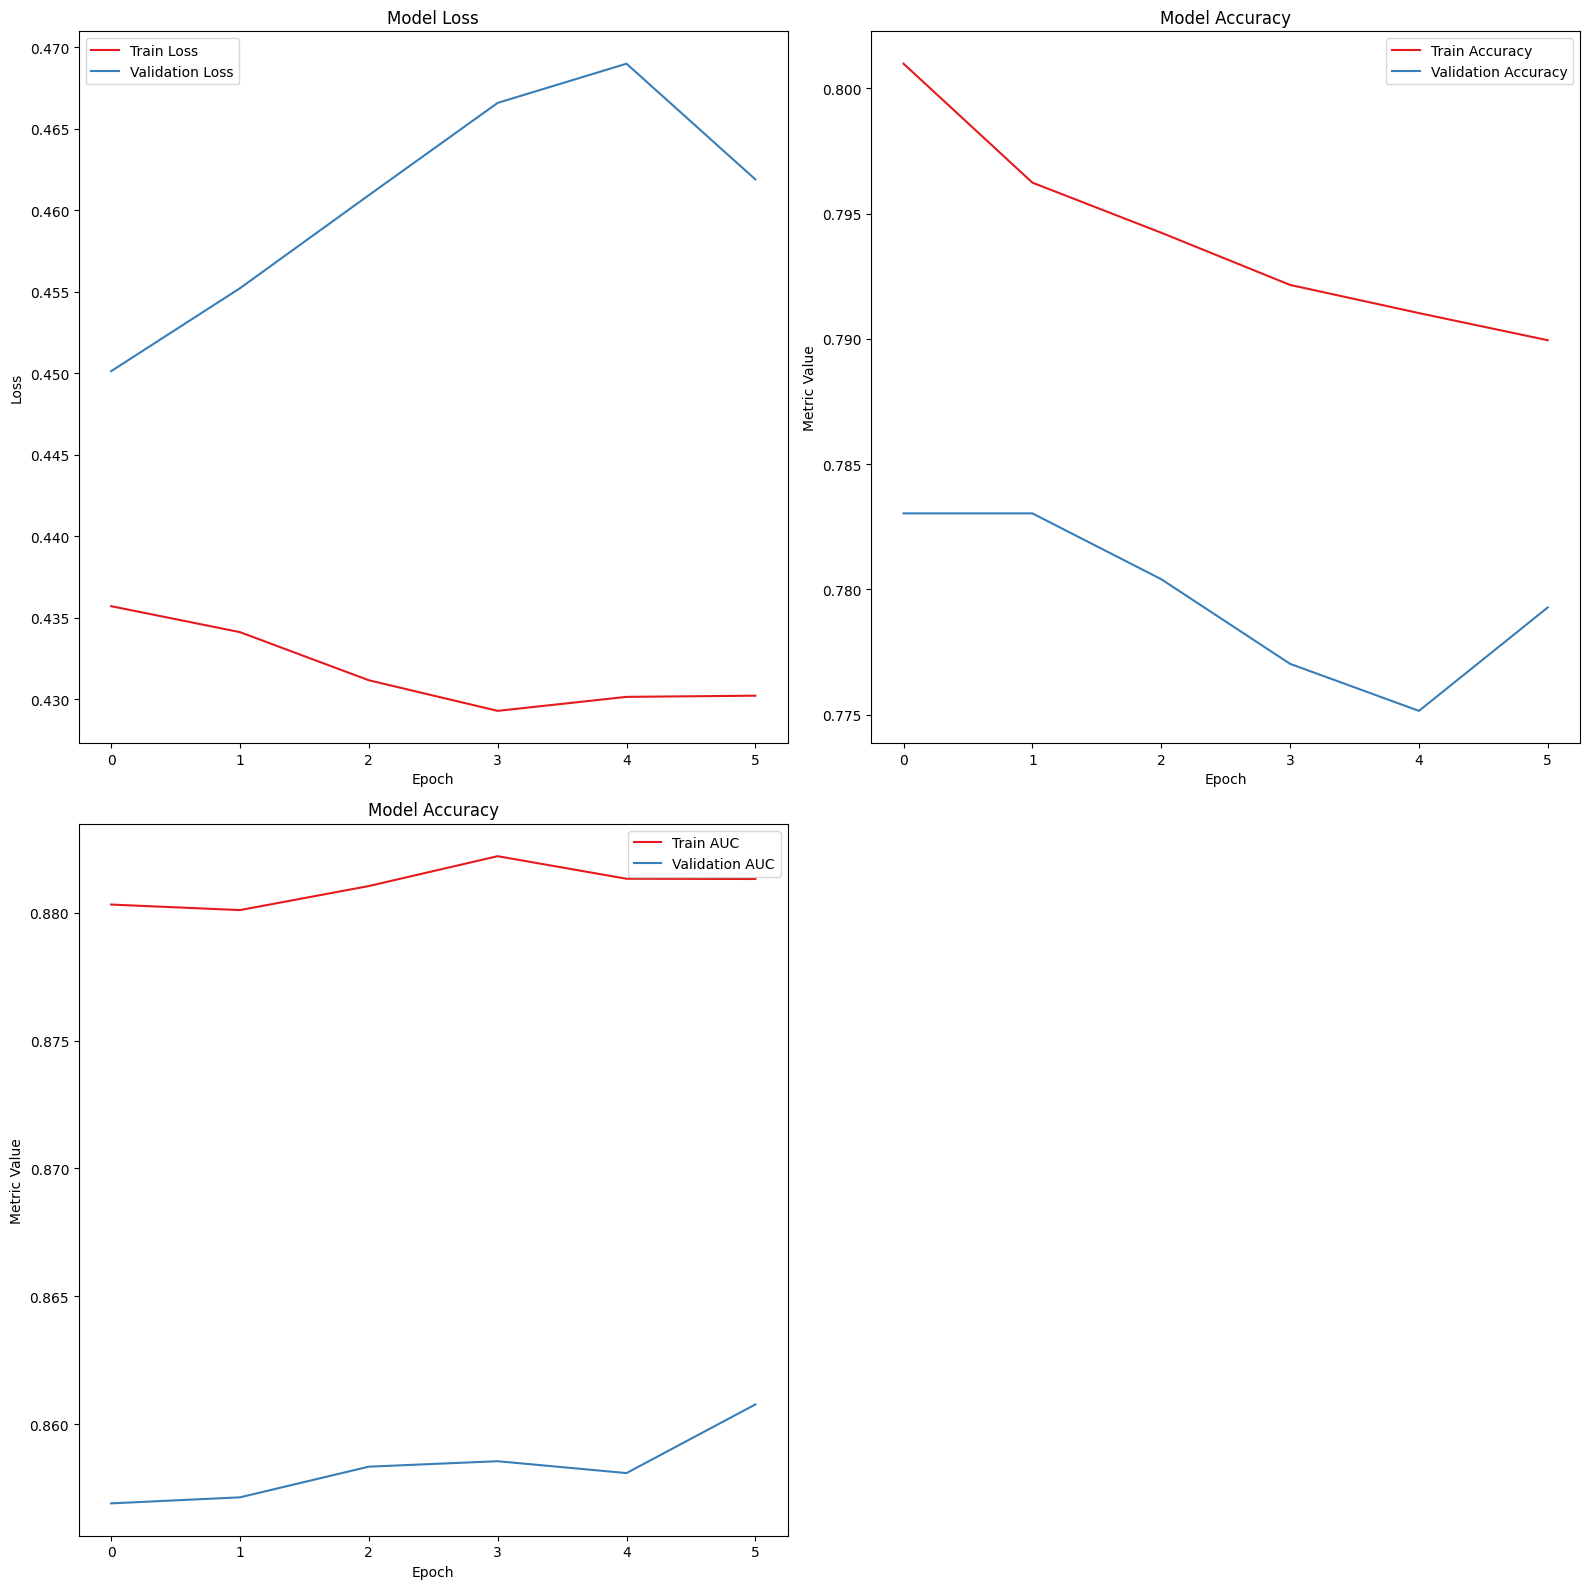

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(222)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(223)
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
test_loss, test_accuracy,test_auc = model.evaluate(val_data,steps=len(val_data), verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

333/333 ━━━━━━━━━━━━━━━━━━━━ 89s 264ms/step - AUC: 0.8625 - accuracy: 0.7887 - loss: 0.4382
Test Loss: 0.4509378671646118
Test Accuracy: 0.7826576828956604
Test AUC: 0.8564730882644653


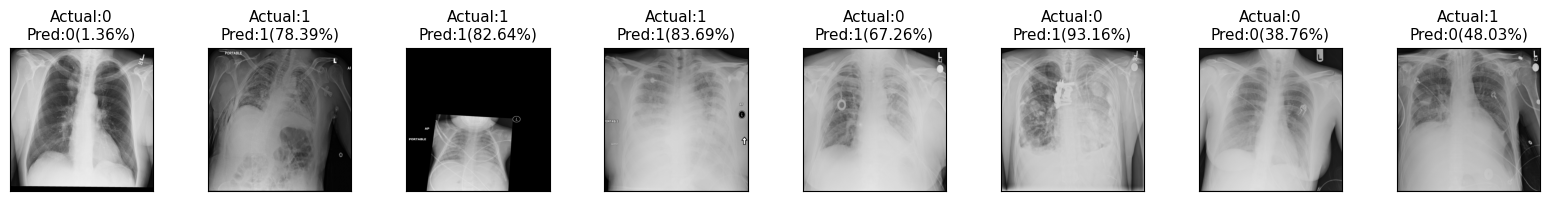

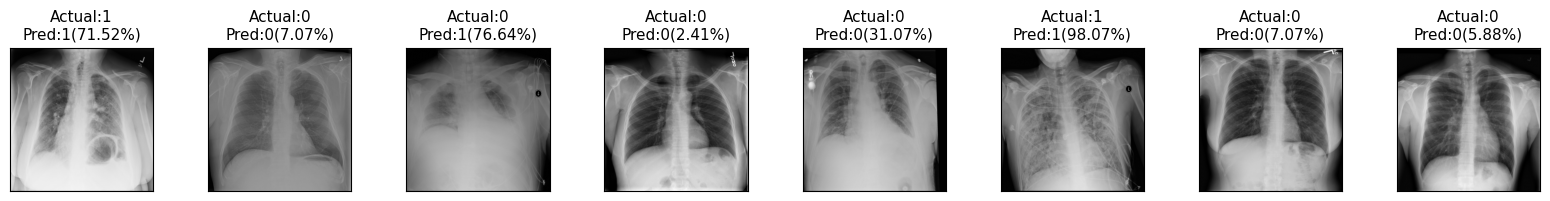

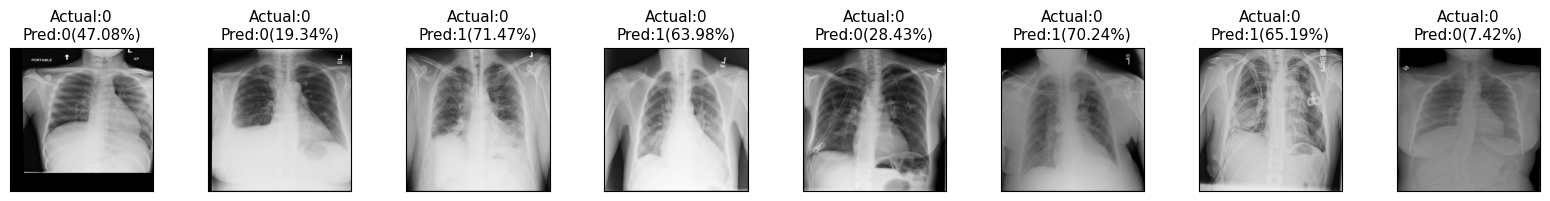

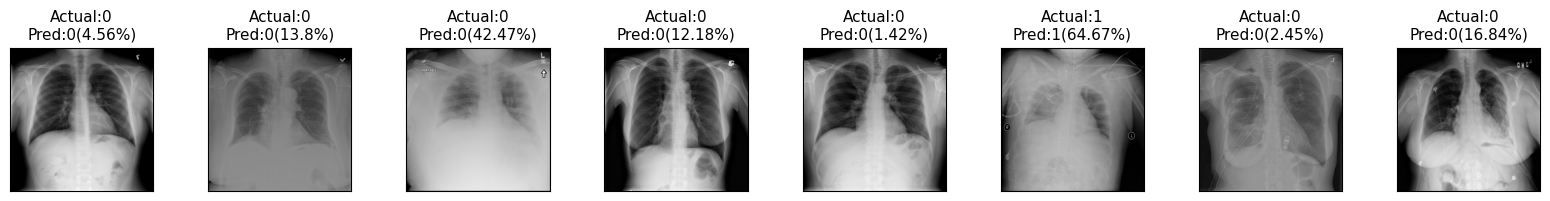

In [17]:
for it in range(4):
    imgs,clss = val_data.__getitem__(it)
    pred_prob = np.squeeze(model.predict(imgs,verbose=0))
    pred_cls = (pred_prob>0.5).astype(int)
    
    fig, ax = plt.subplots(1,8,figsize=(16,2))
    ax = ax.flatten()
    for i,img in enumerate(imgs):
        ax[i].imshow(img)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(f'Actual:{clss[i]}\nPred:{pred_cls[i]}({round(pred_prob[i]*100,2)}%)',fontsize=11)
    
    plt.tight_layout()
    plt.show()